# LEARNER, Auv Navigation and Multisensor Datafor Underwater Robotics

This notebook accompanies the dataset and the report _"LEARNER, Auv Navigation and Multisensor Datafor Underwater Robotics", by Marco Bernardi, Brett Hosking, Chiara Petrioli, Brian J. Bett, Daniel Jones, Veerle Huvenne, Rachel Marlow, Maaten Furlong, Steve McPhail and Andrea Munafo._

> **Abstract** The current maturity of autonomous underwater vehicles (AUVs) has made their deployment practical and cost-effective, such that many scientific, industrial and military applications now include AUV operations. However, the logistical difficulties and high costs of operating at-sea are still critical limiting factors in further technology development, the benchmarking of new techniques and the reproducibility of research results.
To overcome this problem, we present a freely available dataset suitable to test control, navigation, sensor processing algorithms and others tasks. This dataset combines AUV navigation data, side-scan sonar, multibeam echosounder data and seafloor camera image data, and associated sensor acquisition meta-data to provide a detailed characterisation of surveys carried out by the National Oceanography Centre (NOC) in the Greater Haig Fras Marine Conservazion Zone (MCZ) of the U.K in 2015.


This notebook shows how the dataset is structured, how read the data, and provides simple examples on how to use it.

Only minimal processing is done to the data so that, most of the time, the results are showing the raw data as it was acquired during the mission.




Necessary packages:

- `conda install -c anaconda scipy` 
- `conda install -c conda-forge gdal`
- `pip install opencv-python`
- `pip install Pillow`

To integrate it better with jupyter notebook run the following command:
- `python -m ipykernel install --user --name learner --display-name="learner"`

You can now select the correct kernel directly from the Kernel menu.


If your jupyter_client in your environment is <5.3 then you might need to activate the ipyleaflet environment. You can do so, running:

`jupyter nbextension enable --py --sys-prefix ipyleaflet`



Import the necessary packages:

In [54]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle, Polyline, LayersControl

from matplotlib import cm
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d

import pandas as pd
import numpy as np
import pathlib as pl
import datetime

import csv
import math
import random

import time
from datetime import datetime
import warnings

import utils.geodetic
import utils.pyall as pa
import utils.shaded_relief as sr
from utils.palette import *
from utils.emb import *
from utils.utils import *
from utils.camera import *

In [3]:
%matplotlib notebook

In [4]:
%load_ext autoreload
%autoreload 2

Select the data folder:

In [5]:
data_folder = pl.Path('../../to-review/AYE/sample')

# Experimental area: Haig Fras survey area in the Celtic Sea

In [6]:
haig_fras_p      = (50.35, -7.72%360)
haig_fras_bounds = ( (50.20, -7.52%360), (50.55, -7.92%360) )

In [7]:
map_layer = basemap_to_tiles(basemaps.Esri.NatGeoWorldMap)

m = Map(layers=(map_layer, ), center=haig_fras_p, zoom=7)

rectangle = Rectangle(bounds=haig_fras_bounds, name="haig_fras_bounds")

m.add_layer(rectangle)

control = LayersControl(position='topright')
m.add_control(control)

m

Map(center=[50.35, 352.28], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

If the previous cell did not show the map, you most likely need to run

`jupyter nbextension enable --py --sys-prefix ipyleaflet`

# Characterising the area: sound speed and bathymetry

A Conductivity, Temperature Depth (CTD) file is available in the dataset:
  - M086_CTD.csv
  
It contains CTD values for August 10, and 11, 2015. The table below reports the specific values present in the file:

| Variable Name | Meaning |
|---------------|---------------
|T1 °C    | CTD Temperature 1 |
|T2 °C    | CTD Temperature 2 |
|C1       | CTD Conductivity&1 |
|C2       | CTD Conductivity&2 |
|Depth m  | CTD depth |
|DO V     | CTD – Dissolved oxygen reading |
|LSS V    | CTD – Light scattering sensor reading |
|EH V     | CTD – EH Sensor reading |
|rho1 Kg/m3  | CTD – Calculated density1 using the seabird program |
|rho2 Kg/m3  | CTD – Calculated density2 using the seabird program |


The CTD file can be read using the standard pandas read_csv function:

In [8]:
ctd_file = data_folder/'M086_CTD.csv'

In [9]:
ctd_df = pd.read_csv(ctd_file, sep=';')

The CTD file does not contain the sound speed values, but these can be calculated from the available data, for example as:

In [10]:
ssp = []
for index, row in ctd_df.iterrows():
    salinity = conductivityToSalinity(C=row['C1'], t=row['T1'], p=kPaToDecibars(depthToPressure(row['Depth']))) 
    sv = soundVelocity(S=salinity, T=row['T1'], P0=kPaToDecibars(depthToPressure(row['Depth']))) 
    ssp.append(sv)

ctd_df['ssp'] = ssp 

ctd_df.head()

,eTime,eTimeStart,T1,T2,C1,C2,Depth,DO,LSS,EH,rho1,rho2,ssp
0,10-Aug-2015 16:30:02,10-Aug-2015 16:30:01,0.000185,0.000011,18.0502,16.4716,1.539,0.0,-1.7590,998.6018,998.8794,0.0,1430.222524
1,10-Aug-2015 16:30:03,10-Aug-2015 16:30:01,0.000186,0.000014,18.0459,16.4531,1.524,0.0,-1.7591,998.6025,998.8830,0.0,1430.215132
2,10-Aug-2015 16:30:04,10-Aug-2015 16:30:01,0.000199,0.000010,18.0423,16.4627,1.501,0.0,-1.7593,998.6031,998.8810,0.0,1430.208829
3,10-Aug-2015 16:30:05,10-Aug-2015 16:30:01,0.000201,0.000012,18.0402,16.4716,1.492,0.0,-1.7593,998.6035,998.8800,0.0,1430.205198
4,10-Aug-2015 16:30:06,10-Aug-2015 16:30:01,0.000196,0.000010,18.0386,16.4745,1.487,0.0,-1.7594,998.6037,998.8792,0.0,1430.202436


Values can be filtered out using the available timesteps. In the following cells, time is converted to epoch first and then filtered:

In [11]:
epoch_time = eTimeToEpoch(ctd_df['eTime'].values)
ctd_df['epoch'] = epoch_time 

aug_10 = ctd_df['epoch'] < eTimeToEpoch('10-Aug-2015 23:59:59')[0]
aug_11 = ctd_df['epoch'] > eTimeToEpoch('10-Aug-2015 23:59:59')[0]

# and here are the values for August 10, 2015 only
ctd_df[aug_10].head()

,eTime,eTimeStart,T1,T2,C1,C2,Depth,DO,LSS,EH,rho1,rho2,ssp,epoch
0,10-Aug-2015 16:30:02,10-Aug-2015 16:30:01,0.000185,0.000011,18.0502,16.4716,1.539,0.0,-1.7590,998.6018,998.8794,0.0,1430.222524,1.439224e+09
1,10-Aug-2015 16:30:03,10-Aug-2015 16:30:01,0.000186,0.000014,18.0459,16.4531,1.524,0.0,-1.7591,998.6025,998.8830,0.0,1430.215132,1.439224e+09
2,10-Aug-2015 16:30:04,10-Aug-2015 16:30:01,0.000199,0.000010,18.0423,16.4627,1.501,0.0,-1.7593,998.6031,998.8810,0.0,1430.208829,1.439224e+09
3,10-Aug-2015 16:30:05,10-Aug-2015 16:30:01,0.000201,0.000012,18.0402,16.4716,1.492,0.0,-1.7593,998.6035,998.8800,0.0,1430.205198,1.439224e+09
4,10-Aug-2015 16:30:06,10-Aug-2015 16:30:01,0.000196,0.000010,18.0386,16.4745,1.487,0.0,-1.7594,998.6037,998.8792,0.0,1430.202436,1.439224e+09


<IPython.core.display.Javascript object>


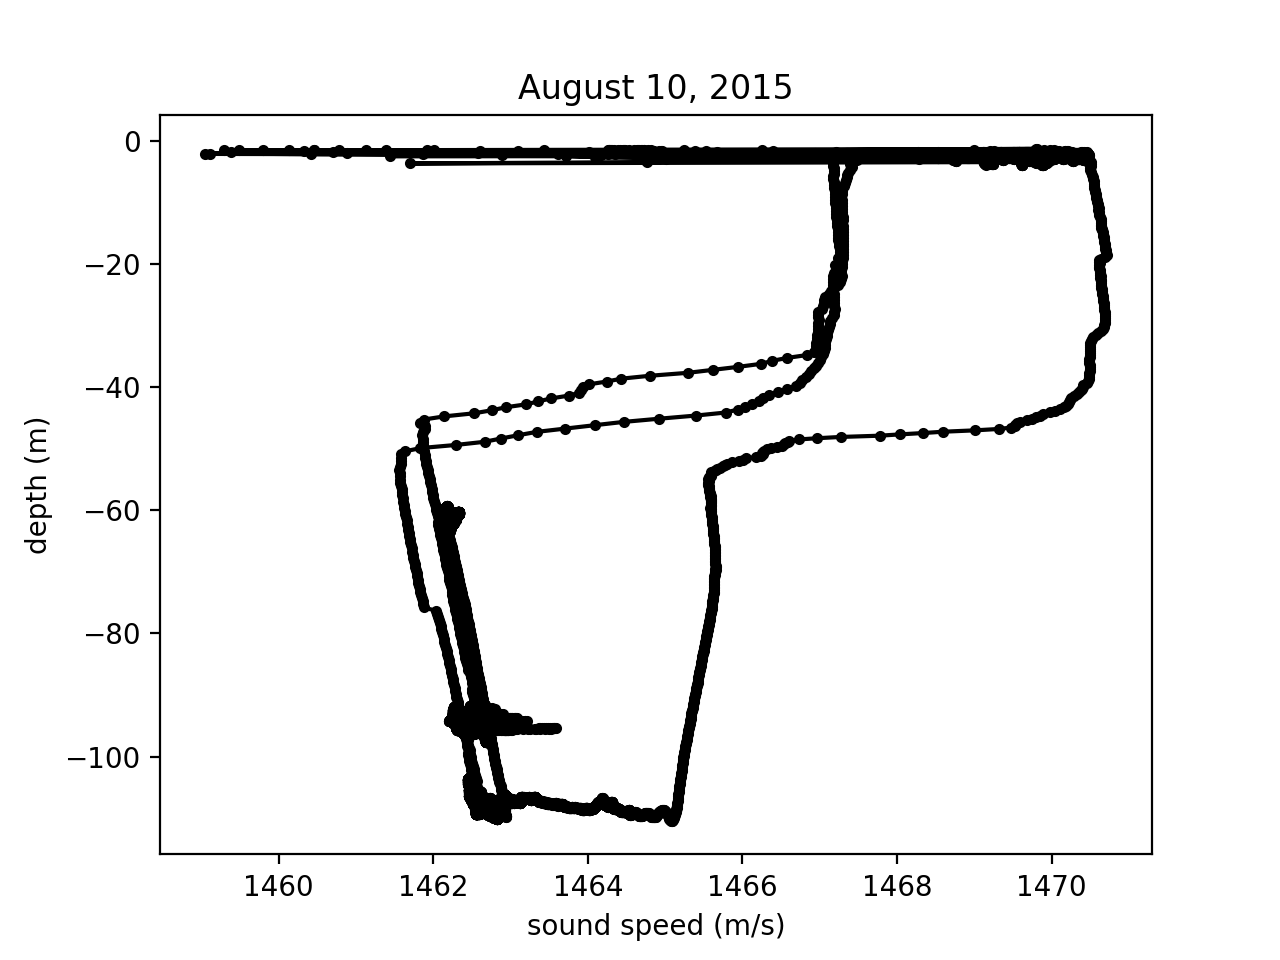

Text(0.5, 1.0, 'August 10, 2015')

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)

plt.plot(ctd_df[aug_11]['ssp'], -ctd_df[aug_11]['Depth'], marker='.', color='black')

ax.set_ylabel('depth (m)')
ax.set_xlabel('sound speed (m/s)')
ax.set_title('August 10, 2015')

## Reading MultiBeam Data

The multibeam data can be read in multiple ways:
 - the file 'pointcloud-xyza.xyz' is a csv file that contains the extracted point cloud (x,y,z,amplitude) 
 - reading the raw file (kongsberg `.all` file provided compressed as a zip file)

## Reading the raw multi-beam data

To read the raw multibeam files (.all) we use the [pyall]() open source library.
Please refer to [EM Series Multibeam echo sounders Datagram formats](https://www.kongsberg.com/globalassets/maritime/km-products/product-documents/160692_em_datagram_formats.pdf) for more information.

In [13]:
ems = Emb(data_folder/'raw/M086Concat.all')

In [14]:
ems.read_datagrams()

INFO:utils.emb:Start reading file: ../../to-review/AYE/sample/raw/M086Concat.all
INFO:utils.emb:File ../../to-review/AYE/sample/raw/M086Concat.all read correctly.


We can now plot the read datagrams as a waterfall image. Note that no processing is done and that only the raw depth values are shown.

Before doing that, let's see what has been read:

In [15]:
ems

Emb: 
- x resolution (m): 0.9628704049543032 
- y resolution (m): 0.10903292906159649 
- min depth (m)   : 61.57508850097656 
- max depth (m)   : 129.21498107910156 
- datagram count  : 228930 

In [16]:
img = ems.show(palette=Palette('./utils/jeca.pal'), idxs=[38390-2000,38390])

/Users/andreamunafo/Downloads/workspace/ocean-data/utils/shaded_relief.py:59: UserWarning: Warning: converting a masked element to nan.
  Zbc[-1, 0] = elevGrid[-1, 0]
/Users/andreamunafo/Downloads/workspace/ocean-data/utils/shaded_relief.py:60: UserWarning: Warning: converting a masked element to nan.
  Zbc[-1, -1] = elevGrid[-1, 0]


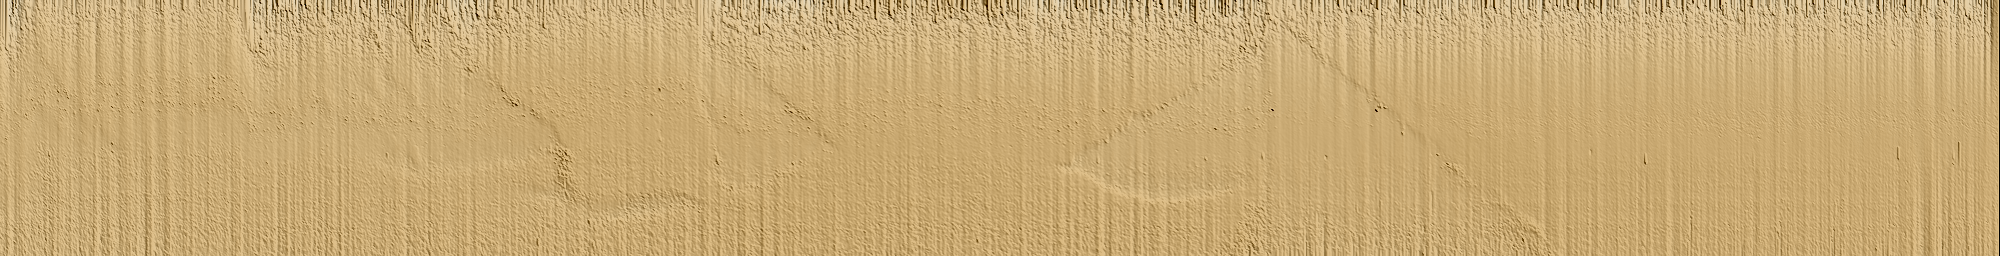

In [17]:
img.rotate(90, expand=True)

We can now close the reader

In [18]:
ems.close()

### Multi-Beam point cloud

From the raw data it is possible to create a point cloud. The dataset includes a point cloud file already which has been extracted with [SonarWiz](https://chesapeaketech.com/products/sonarwiz-sidescan/) for convenience.

In [59]:
pc_file = data_folder/'pointcloud-xyza.xyz'

Read the file:

In [7]:
x,y,z,a = np.loadtxt(pc_file, skiprows=1, delimiter=",", unpack = True)

And plot it. Note that the file contains more than 9 millions points, too many to be easily plotted here, so we only select a subset:

<IPython.core.display.Javascript object>


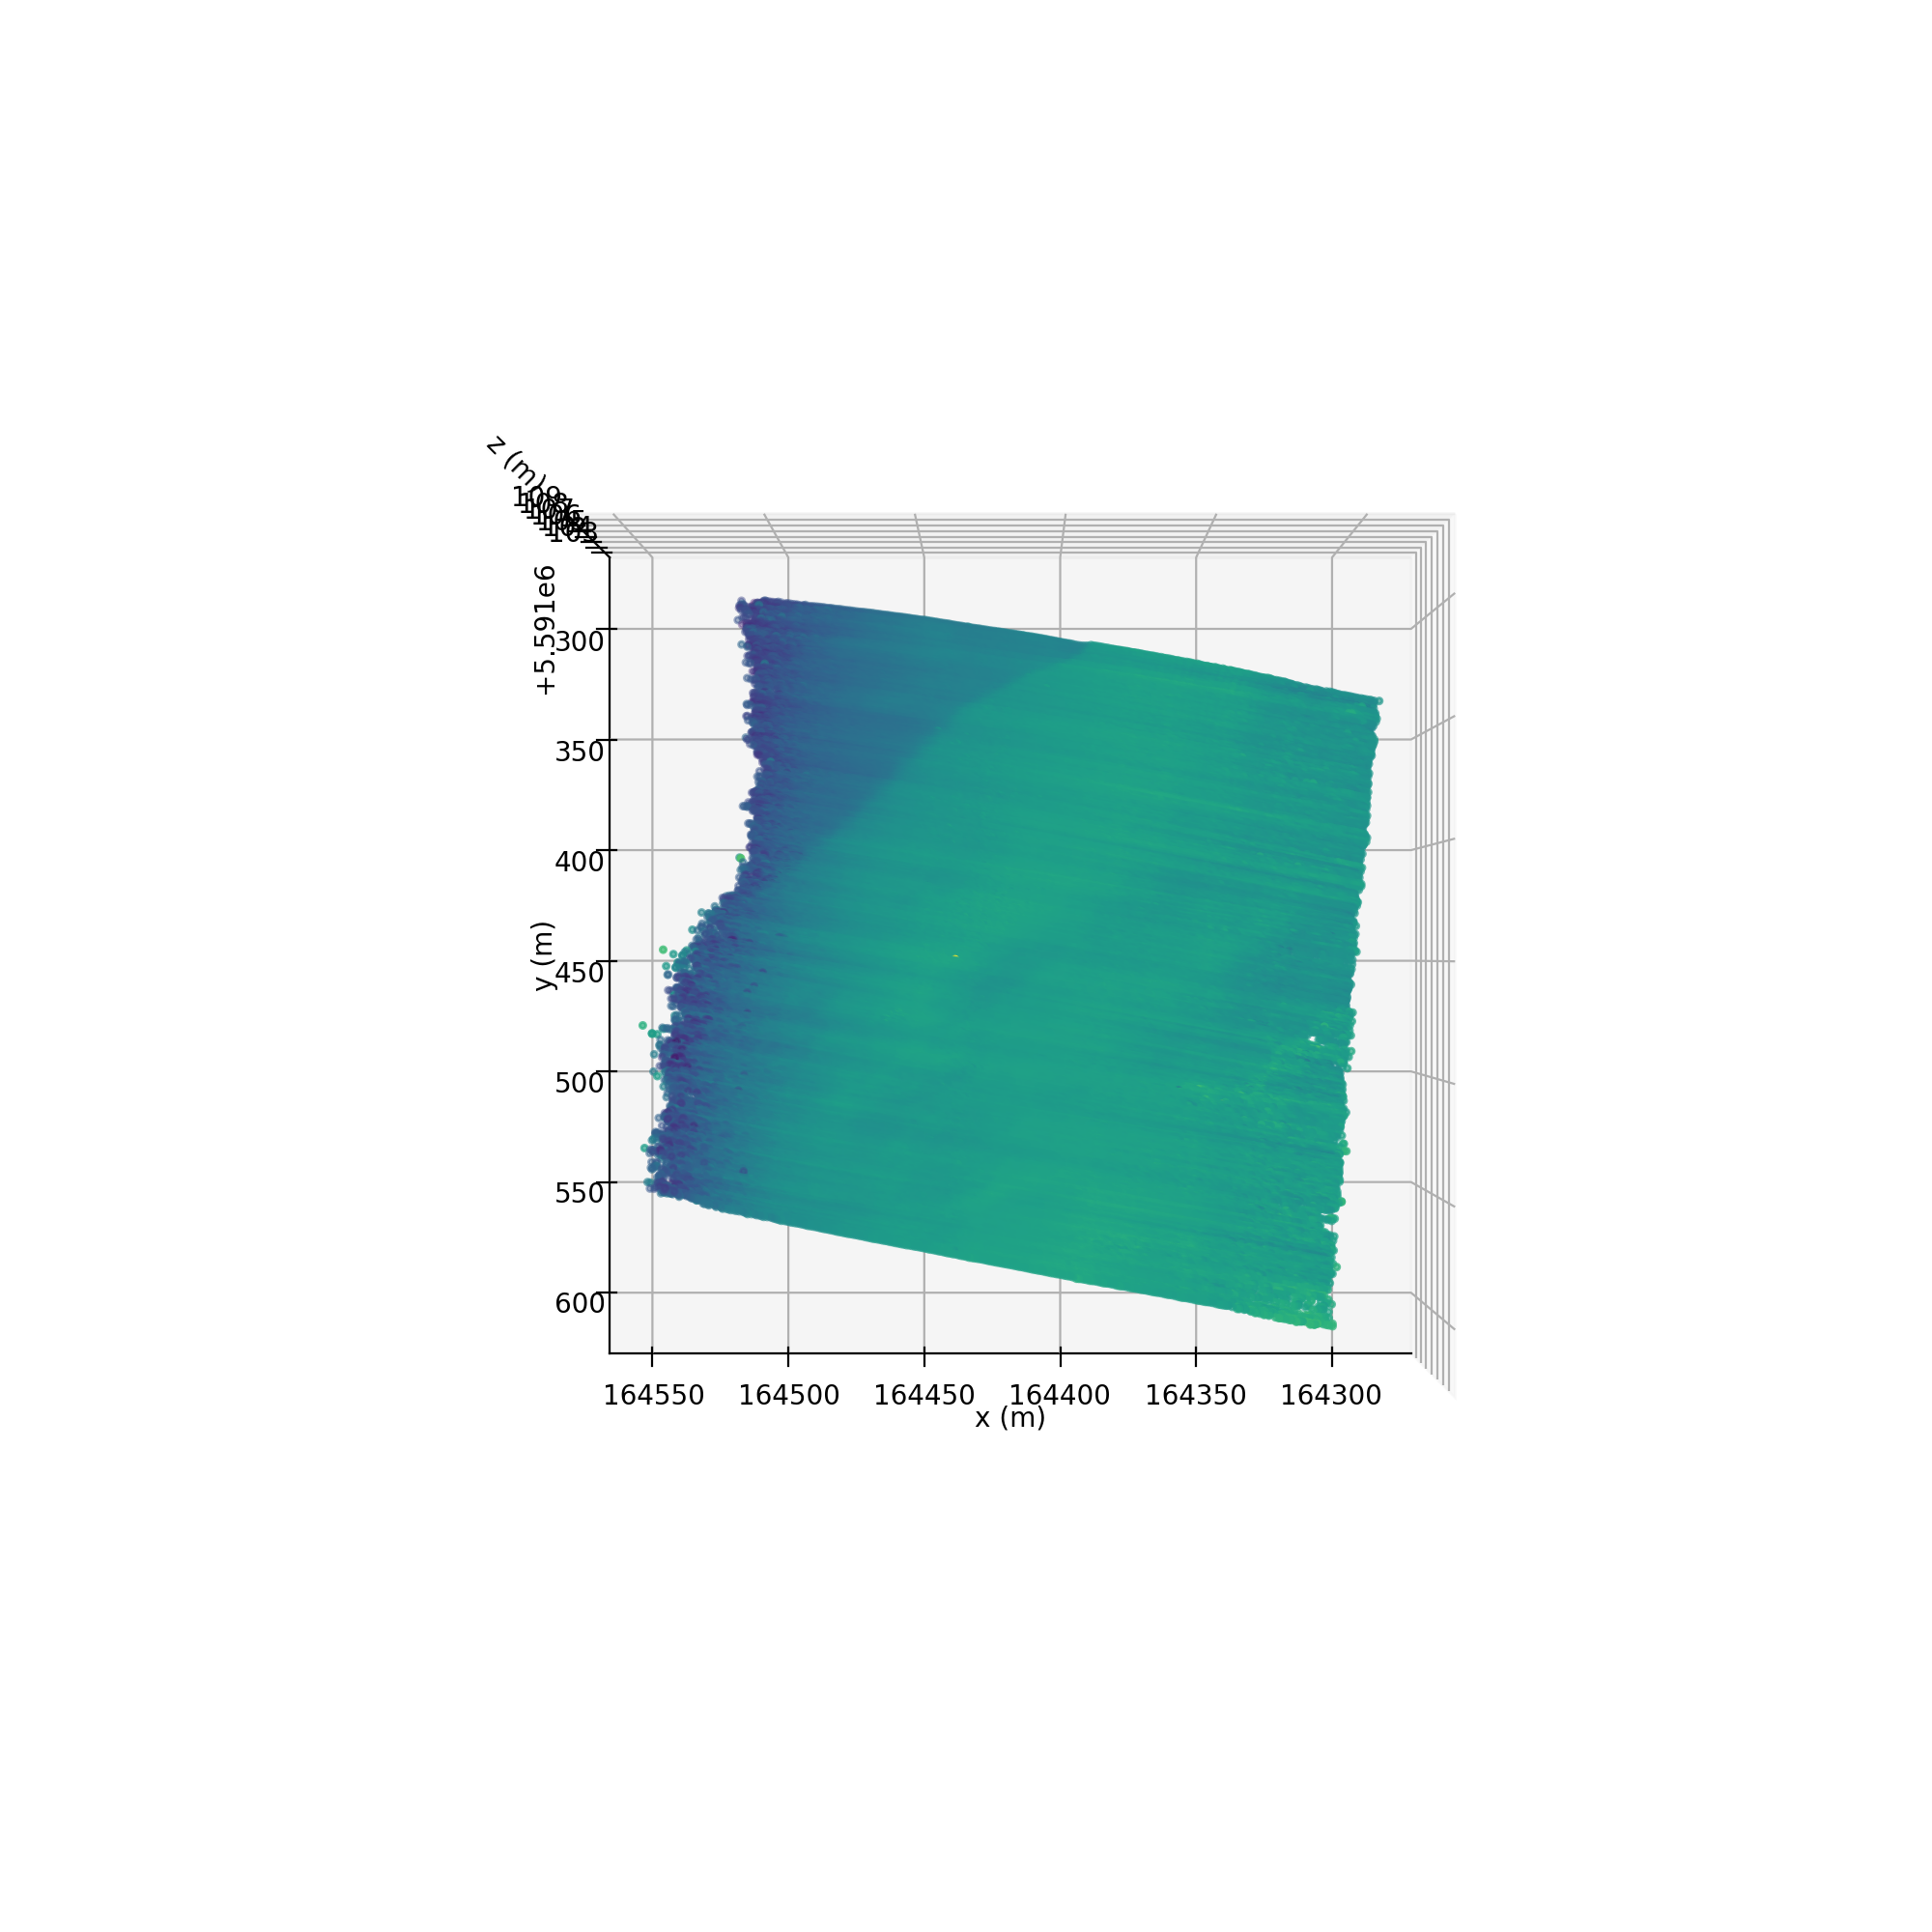

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[1000000:1100000], y[1000000:1100000], z[1000000:1100000], c=z[1000000:1100000], marker='.')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')
ax.view_init(elev=90., azim=90)
plt.show()

# Side scan sonar

# Camera images

List the camera image files:

In [65]:
camera_files = list((data_folder/'vertical-camera-raw/').rglob('*.*'))

n_files = len(camera_files)
print(f'Number of files: {n_files}')

Number of files: 11331


In [107]:
source_image = camera_files[6]
dest_image = "./result.png"

print(f'Reading file: {source_image}')
print(f'Saving to file: {dest_image}')

Reading file: ../../to-review/AYE/sample/vertical-camera-raw/Test48_13331848_13083849942670.raw
Saving to file: ./result.png


Let's define a simple wrapper on top of opencv functions to read the raw image and convert it to the correct color space:

In [108]:
def convertBayerToRGB(path_source, path_result, col, row):
    """
    convertBayerToRGB reads a raw image, converts it to RGB and saves it to file.
    arguments:
     - path_raw: path of the origin image
     - path_resul: path where to save the final image
     - col, row: values used to reshape the final image
    """
    
    rawimg = open(path_source,"rb")
    img = np.fromfile(rawimg, np.dtype('u1'), col * row).reshape(row, col)
    img.tofile(path_source)
    colimg = cv2.cvtColor(img, cv2.COLOR_BAYER_GB2RGB)
    cv2.imwrite(path_result, colimg)

We can now convert the image

In [147]:
convertBayerToRGB(source_image, dest_image, col=2448, row=2048)

and show what we have read

<IPython.core.display.Javascript object>


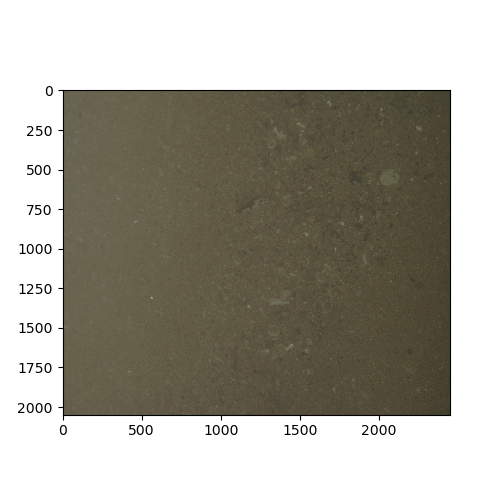

In [150]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.imshow(Image.open(dest_image))

We can now process the entire directory.

Let's create a new folder first:

In [63]:
path = pl.Path.cwd() / 'processed-images'
path.mkdir()

Run the next cell to batch process all the images. Note that this might take a while. On my i7 took ~20.7s to process 100 images.

In [140]:
%%time
for idx, cfn in enumerate(camera_files):
    source_image = cfn
    dest_image = str(path/cfn.name[:-4])+'.png'
    try:
        convertBayerToRGB(source_image, dest_image, col=2448, row=2048)
    except:
        print(f'Error while reading: {source_image}')
    
    # Uncomment the next line if you only want to process the first 100 images.
#     if idx >= 100: break

Error while reading: ../../to-review/AYE/sample/vertical-camera-raw/Test48_13331848_13083845865668.raw
CPU times: user 18.2 s, sys: 2.51 s, total: 20.7 s
Wall time: 20.7 s


Let's plot a random sample of the result:

<IPython.core.display.Javascript object>


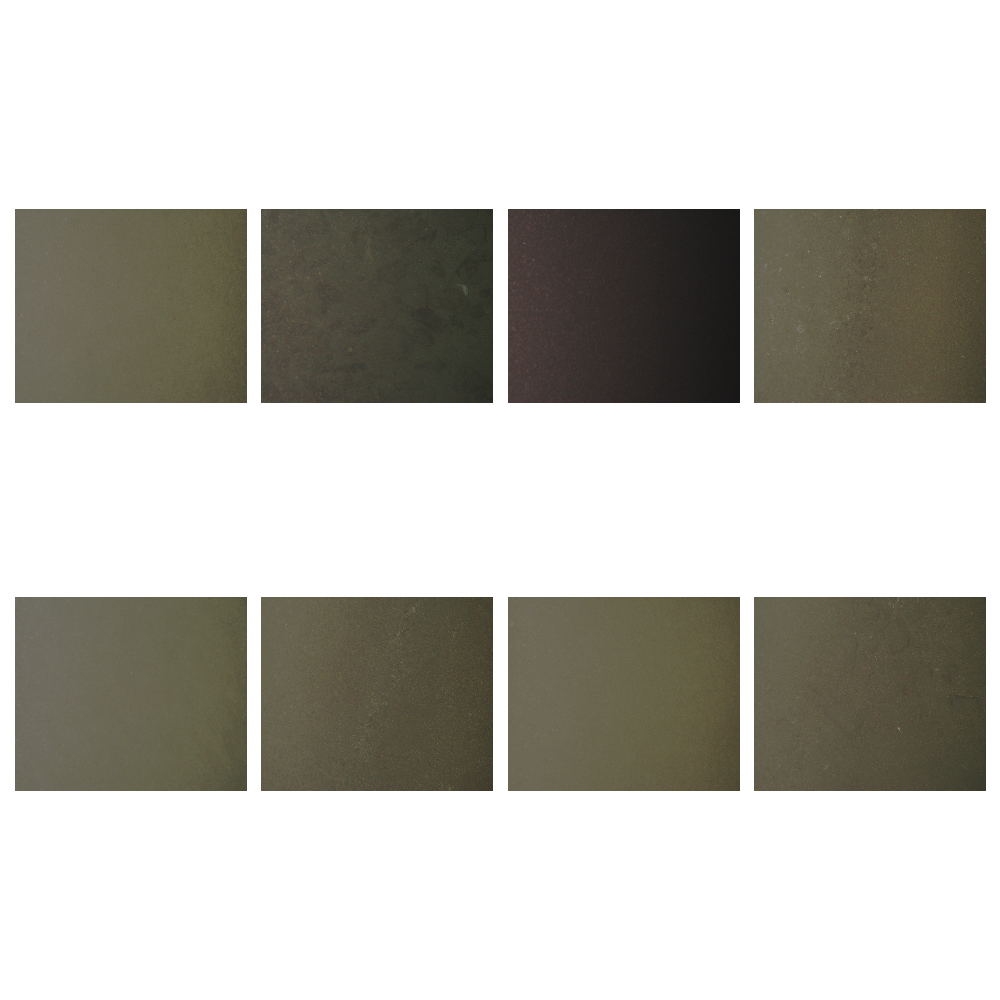

In [146]:
pimgs = list(path.rglob('*.*'))

sel_imgs = random.sample(pimgs, k=8)


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,10))

col = -1
for idx, im in enumerate(sel_imgs):
    row = idx % 2
    col = col+1 if idx % 2 == 0 else col
    ax[row][col].imshow(Image.open(im))
    ax[row][col].axis('off')
    
plt.tight_layout()

# AUV Navigation

The vehicle navigation is stored in multiple files, depending on the specific mission run.
Autosub 6000 saves its variables at 1Hz. If no new data is available, the old data is stored.

For Mission 86, the AUV variables are recorded in `multi-beam-echosounder-index.csv`.


AUV rotations are Euler angles using the yaw/pitch/roll sequence convention.

The vehicle was equipped with a ADCP to track water and ground velocities.
Each ADCP bin has its own : Inten3_Y, IntenY, VeastY, VnorthY, VdownY, VerrY where Y is the bin number. 
There are 15 bins in the ADCP configuration for this cruise.



| Variable Name | Description |
| --------------|-----------------|
|Date		    |    Date of record to nearest day (DD-Mon-YYYY) |
|Time		    |    Time of record to the nearest second (HH:MM:SS) |
|Seconds		| Seconds since first record in file |
|Latitude	(Deg)	| AUV Latitude
|Longitude	(Deg)	| AUV Longitude
|depth		(m)     | AUV Depth
|altitude	(m)     | AUV altitude above the seafloor. Values of 1000m mean out of range   |
|Roll		(rad)   |    AUV roll  |
|Pitch		(rad)   |    AUV pitch  |
|Heading		(rad) |  AUV heading |
|WaterSpeed		(m/s) |  AUV speed through the water calculated from the ADCP bins       |
|GroundSpeed	(m/s) |  AUV speed over ground determined using the DVL |
|MagX		(microTesla) |  Magnetometer raw X-value reading
|MagY		(microTesla) |  Magnetometer raw Y-value reading
|MagZ		(microTesla) |  Magnetometer raw Z-value reading
|Temperature	(oC)	|  Magnetometer temperature |
|Mspare1		|  Not used 
|Mspare2		|  Not used
|Mspare3		|  Not used
|MgB_low		|  TBC
|MgB_mid		|  TBC
|MgB_high		|  TBC
|T1		(oC) |   CTD Temperature 1
|T2		(oC) |   CTD Temperature 2
|C1		|   CTD Conductivity 1
|C2		|   CTD Conductivity 2
|Depth	(m)  | CTD depth
|DO		(V) | CTD dissolved oxygen
|LSS	(V)	| CTD Light scattering sensor
|EH		(V) | CTD EH sensor
|rho1	(Kg/m3)	| CTD, density calculated using the seabird program
|rho2	(Kg/m3)	| CTD, density calculated using the seabird program
|CorMg0		|  Correlation magnitude for bottom track
|Inten0		(0.24dB) | Beam 1 signal intensit
|Veast0		(mm/s) | Side velocity bin for bottom tracking, in the AUV frame of reference. Positive if AUV is moving to port |
|Vnorth0	(mm/s)	| Forward velocity in AUV frame. Forward motion produces a negative value for this
|Vdown0		(mm/s)  | AUV Down velocity. AUV motion down produce negative value | 
|Verr0		(mm/s) | Error velocity
|ADCPVersion		|  Version number
|ADCPRev		|  Revision number
|HeadBias		(0.01 Deg) | Always 0
|NumWatPings		|  Number of water pings per ensemble. Always 1.
|CellSize		(cm) | ADCP cell size in cm. (e.g. 800) |
|BlankSize		(cm) | ADCP blanking period in cm |
|NumCells		| ADCP number of water track cells
|MinThresh		|
|HeadAlign		(0.01 Deg) | Heading align (critical to navigation) | 
|Salinity		(PSU) |  Fixed salinity for ADCP sound velocity correction (e.g. 35).
|SoundSpeed		(m/sec) | Speed of Sound that the ADCP calculates at zero depth (T and S correction only)
|ADCPTemp		(oC) | Temperature measured at the ADCP head
|Inten3_Y		(0.24dB)|  Beam 3 signal intensity. 
|IntenY	(0.24dB) | Beam Y signal intensity
|VeastY		(mm/s) | Side velocity bin Y. In AUV frame of reference. If AUV is moving to port, then this number is positive.
|VnorthY	(mm/s) | Forward velocity in AUV frame. Forward motion produces a negative value for this
|Vdown1		(mm/s) | ADCP down velocity. AUV motion down produce negative values.
|VerrY		(mm/s) | ADCP Error velocity

In [19]:
auv_data_df = pd.read_csv(data_folder/'multi-beam-echosounder-index.csv', sep=',', low_memory=False)

In [20]:
auv_data_df.head()

,Date,Time,Seconds,Latitude,Longitude,depth,altitude,Roll,Pitch,Heading,...,Veast14,Vnorth14,Vdown14,Verr14,Inten3_15,Inten15,Veast15,Vnorth15,Vdown15,Verr15
0,10-Aug-2015,16:30:00,-7958,50.333973,-7.711981,-0.421316,1000.000000,0.063879,-0.016162,0.083112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-Aug-2015,16:30:02,-7956,50.333973,-7.711983,-0.421316,1000.000000,0.031870,-0.023911,0.073164,...,NaN,NaN,NaN,NaN,0.000000,41.000000,NaN,NaN,NaN,NaN
2,10-Aug-2015,16:30:04,-7954,50.333973,-7.711986,-0.384176,1000.000000,-0.006109,-0.010786,0.067317,...,NaN,NaN,NaN,NaN,0.000000,41.000000,NaN,NaN,NaN,NaN
3,10-Aug-2015,16:30:06,-7952,50.333973,-7.711987,-0.421316,1000.000000,0.000227,0.009634,0.078348,...,NaN,NaN,NaN,NaN,0.000000,41.000000,NaN,NaN,NaN,NaN
4,10-Aug-2015,16:30:08,-7950,50.333973,-7.711989,-0.384464,1000.000000,0.037332,0.008186,0.092066,...,NaN,NaN,NaN,NaN,0.000000,41.000000,NaN,NaN,NaN,NaN


Some cells have additonal blanks and this might make pandas not able to import them correctly. To remove them:

In [21]:
auv_data_df.columns = auv_data_df.columns.str.replace(' ','')

In [29]:
auv_latitude  = auv_data_df['Latitude'].to_numpy(dtype=np.float32)
auv_longitude = auv_data_df['Longitude'].to_numpy(dtype=np.float32)

We can now plot the AUV longitude and latitude. We also plot, the deployment point of the vehicle (in green) and its recovery point (in red)

<IPython.core.display.Javascript object>


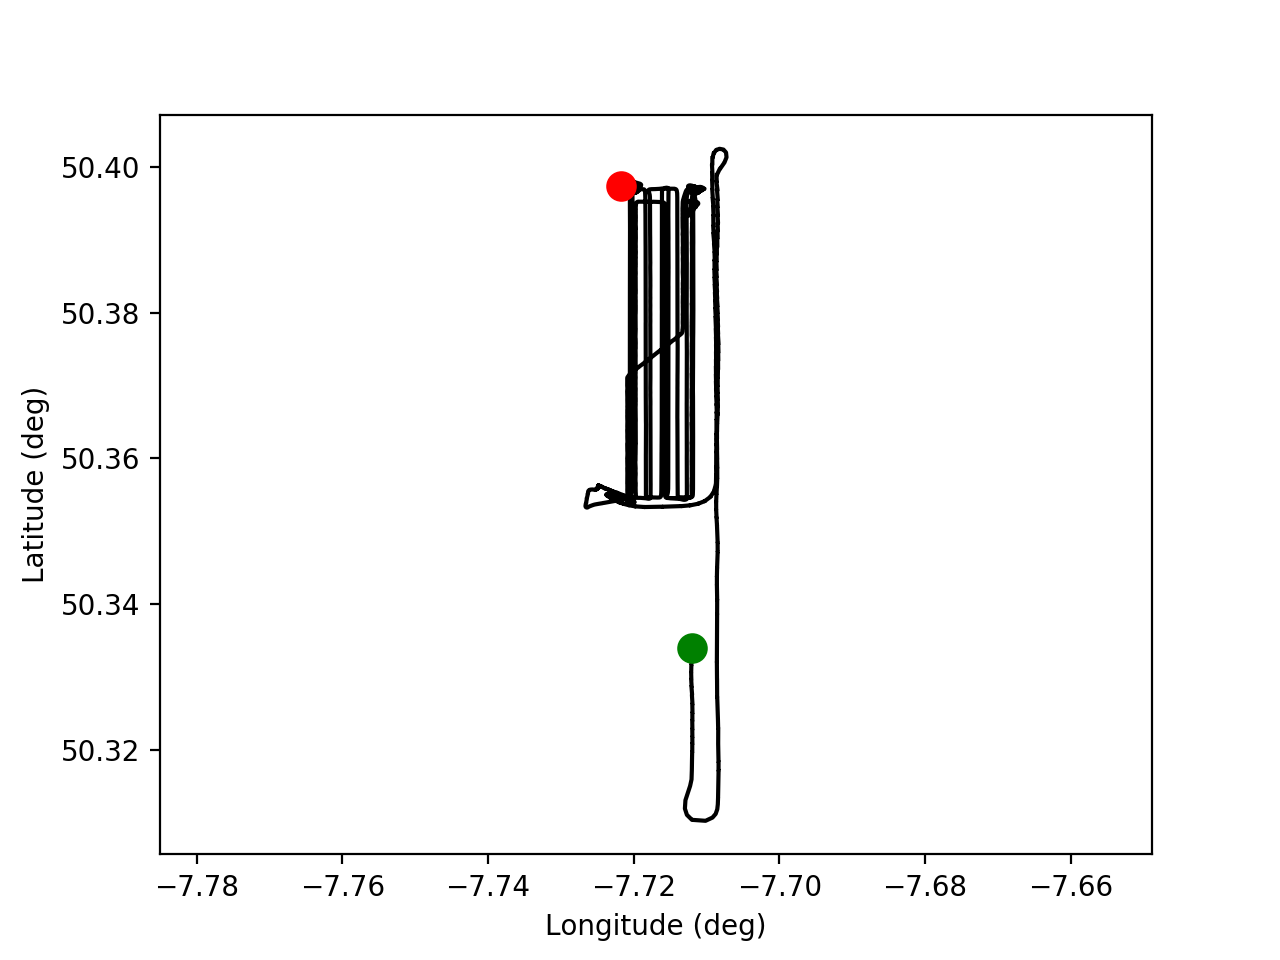

(-7.7275841474533085,
 -7.706282830238342,
 50.305640029907224,
 50.407128524780276)

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(auv_longitude, auv_latitude, color='k')
plt.plot(auv_longitude[0], auv_latitude[0], color='g', marker='.', markersize=20)
plt.plot(auv_longitude[-2], auv_latitude[-2], color='r', marker='.', markersize=20)
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
ax.axis('equal')

To show the trajectory on the map, we need to convert them into a list. We also decimate them with a factor of 50, since we do not to be extremly precise for this.

In [34]:
auv_path = []
for lat, lon in zip(auv_latitude[0:-2:50], auv_longitude[0:-2:50]):    
    auv_path.append([lat, lon])    

In [35]:
auv_line = Polyline(
    locations=auv_path,
    color="black" ,
    fill=False,
    name="auv_mbes_path",
)
m.center = auv_path[0]

m.add_layer(auv_line)

In [36]:
m

Map(center=[50.333973, -7.711981], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

More variables can be plotted in the same way.

In [38]:
auv_pitch  = auv_data_df['Pitch'].to_numpy(dtype=np.float32)

In [39]:
auv_pitch

array([-0.016162, -0.023911, -0.010786, ..., -0.023405, -0.013282,
             nan], dtype=float32)

<IPython.core.display.Javascript object>


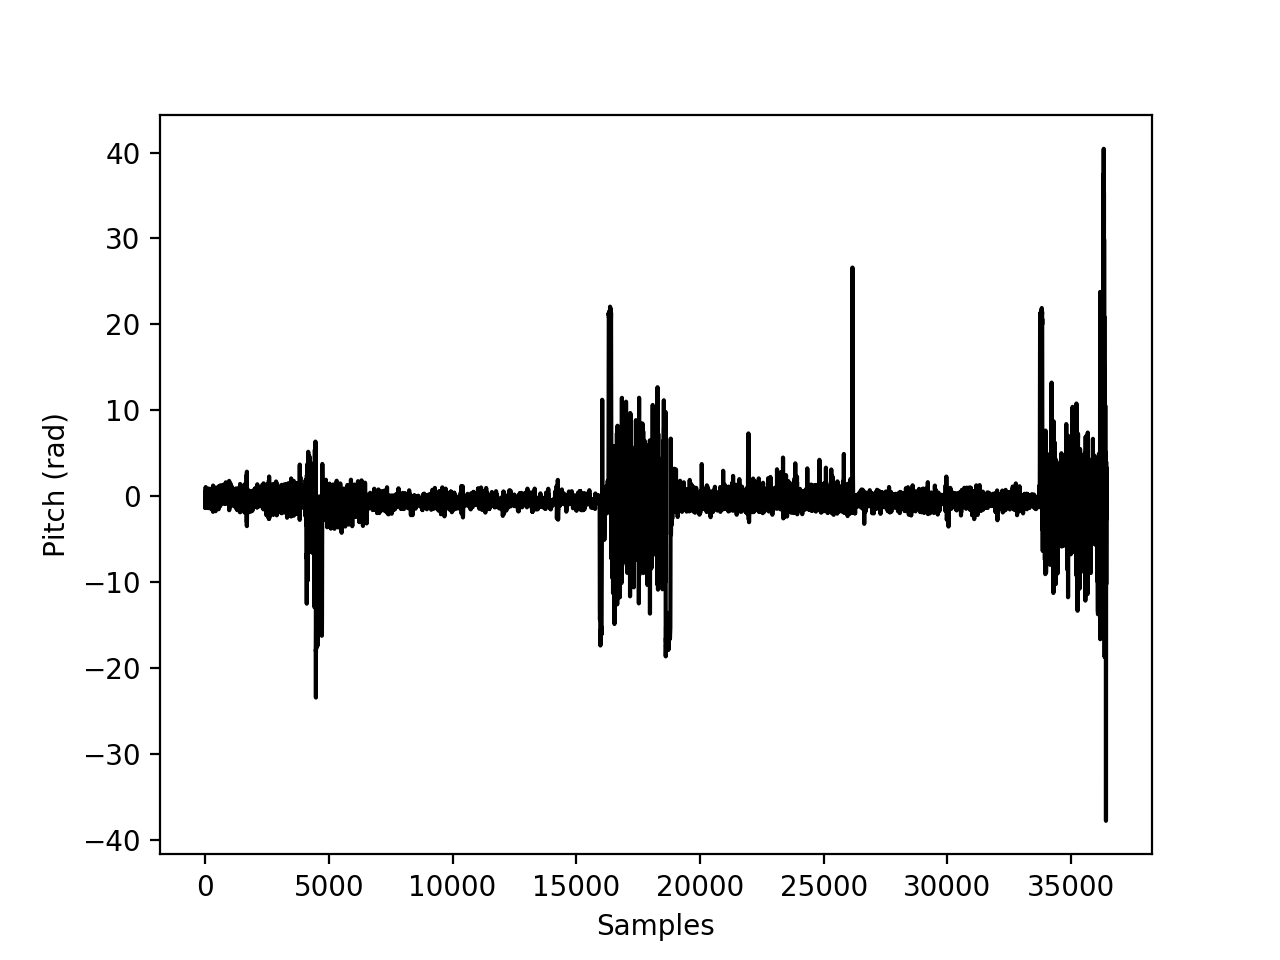

Text(0, 0.5, 'Pitch (rad)')

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(auv_pitch*180/3.14, color='k')
ax.set_xlabel('Samples')
ax.set_ylabel('Pitch (rad)')

# References

- [1] [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet)
- [2] [ipyleaflet, API](https://ipyleaflet.readthedocs.io/en/latest/api_reference/rectangle.html)
- [3] [maps in jupyter](https://blog.jupyter.org/interactive-gis-in-jupyter-with-ipyleaflet-52f9657fa7a)
- [4] [geonotebook](https://github.com/OpenGeoscience/geonotebook)